In [1]:
# ============================================
# 1) IMPORT & BASIC SETUP
# ============================================

In [2]:
!pip install -U "scikit-learn>=1.4.2" "scikeras>=0.13.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 31.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [3]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px

import math
from joblib import Parallel, delayed
import PIL
from PIL import Image
import os
import warnings
warnings.filterwarnings('ignore')

In [4]:
!pip install kagglehub
!pip install scikeras

In [5]:
!pip install kaggle

In [6]:
!mkdir ~/.kaggle

In [7]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [8]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

User uploaded file "kaggle.json" with length 67 bytes


In [9]:
!mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [10]:
!kaggle competitions list

ref                                                                                 deadline             category                reward  teamCount  userHasEntered  
----------------------------------------------------------------------------------  -------------------  ---------------  -------------  ---------  --------------  
https://www.kaggle.com/competitions/ai-mathematical-olympiad-progress-prize-3       2026-04-15 23:59:00  Featured         2,207,152 Usd        530           False  
https://www.kaggle.com/competitions/hull-tactical-market-prediction                 2025-12-15 23:59:00  Featured           100,000 Usd       3121           False  
https://www.kaggle.com/competitions/vesuvius-challenge-surface-detection            2026-02-13 23:59:00  Research           100,000 Usd        258           False  
https://www.kaggle.com/competitions/google-tunix-hackathon                          2026-01-12 23:59:00  Featured           100,000 Usd         72           False  
https://ww

In [11]:
# ลองเช็คว่า login ได้
!kaggle competitions list | head

ref                                                                                 deadline             category                reward  teamCount  userHasEntered  
----------------------------------------------------------------------------------  -------------------  ---------------  -------------  ---------  --------------  
https://www.kaggle.com/competitions/ai-mathematical-olympiad-progress-prize-3       2026-04-15 23:59:00  Featured         2,207,152 Usd        530           False  
https://www.kaggle.com/competitions/hull-tactical-market-prediction                 2025-12-15 23:59:00  Featured           100,000 Usd       3121           False  
https://www.kaggle.com/competitions/vesuvius-challenge-surface-detection            2026-02-13 23:59:00  Research           100,000 Usd        258           False  
https://www.kaggle.com/competitions/google-tunix-hackathon                          2026-01-12 23:59:00  Featured           100,000 Usd         72           False  
https://ww

In [12]:
import kagglehub

In [13]:
# Download latest version
path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-dataset")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'fashion-product-images-dataset' dataset.
Path to dataset files: /kaggle/input/fashion-product-images-dataset


In [14]:
import os

print("Path =", path)
!ls $path
!ls $path/fashion-dataset | head

Path = /kaggle/input/fashion-product-images-dataset
fashion-dataset
fashion-dataset
images
images.csv
styles
styles.csv


In [15]:
csv_path = os.path.join(path, "fashion-dataset", "styles.csv")
images_dir = os.path.join(path, "fashion-dataset", "images")

In [16]:
print("CSV exists:", os.path.exists(csv_path))
print("Images dir exists:", os.path.exists(images_dir))

CSV exists: True
Images dir exists: True


In [17]:
# ============================================
# 4) LOAD CSV + เลือกเฉพาะ 5 classes (Topwear, Shoes, Bottomwear, Bags, Watches)
# ============================================

In [18]:
styles = pd.read_csv(csv_path, on_bad_lines='skip')
print("Raw styles shape:", styles.shape)
styles.head()

Raw styles shape: (44424, 10)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [19]:
# ดู distribution คร่าว ๆ ก่อน
styles['subCategory'].value_counts().head(20)

,count
subCategory,
Topwear,15402
Shoes,7343
Bags,3055
Bottomwear,2694
Watches,2542
Innerwear,1808
Jewellery,1079
Eyewear,1073
Fragrance,1011


In [20]:
# เลือกเฉพาะ 5 class
target_classes = ['Topwear', 'Shoes', 'Bottomwear', 'Bags', 'Watches']

styles_small = styles[styles['subCategory'].isin(target_classes)].reset_index(drop=True)
print("After filtering 5 classes:", styles_small.shape)
styles_small['subCategory'].value_counts()


After filtering 5 classes: (31036, 10)


,count
subCategory,
Topwear,15402
Shoes,7343
Bags,3055
Bottomwear,2694
Watches,2542


In [21]:
# ============================================
# 5) BALANCE DATA: sample N_PER_CLASS ต่อ class
# ============================================

In [22]:
N_PER_CLASS = 1000

styles_small = (
    styles_small
    .groupby('subCategory', group_keys=False)
    .apply(lambda x: x.sample(n=min(N_PER_CLASS, len(x)), random_state=101))
    .reset_index(drop=True)
)


In [23]:
print("After sampling per class:")
print(styles_small['subCategory'].value_counts())
print("Total:", len(styles_small))

After sampling per class:
subCategory
Bags          1000
Bottomwear    1000
Shoes         1000
Topwear       1000
Watches       1000
Name: count, dtype: int64
Total: 5000


In [24]:
# ============================================
# 6) ENCODE LABEL + TRAIN/VAL/TEST SPLIT
# ============================================

In [25]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

encoder = LabelEncoder()
styles_small['label'] = encoder.fit_transform(styles_small['subCategory'])

print("Class mapping:", dict(enumerate(encoder.classes_)))


Class mapping: {0: 'Bags', 1: 'Bottomwear', 2: 'Shoes', 3: 'Topwear', 4: 'Watches'}


In [26]:

train_df, test_df = train_test_split(
    styles_small,
    test_size=0.2,
    stratify=styles_small['label'],
    random_state=101
)

train_df, val_df = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df['label'],
    random_state=101
)


In [27]:
print("Train/Val/Test sizes:", len(train_df), len(val_df), len(test_df))

Train/Val/Test sizes: 3200 800 1000


In [28]:
# ============================================
# 7) IMAGE LOADING FUNCTION (28x28 grayscale + normalize + flatten)
# ============================================

In [29]:
image_size = (28, 28)

def load_img_flat(img_id, size=image_size):
    path_img = os.path.join(images_dir, f"{int(img_id)}.jpg")
    if not os.path.exists(path_img):
        return None
    img = Image.open(path_img).convert("L").resize(size)  # grayscale + resize
    arr = np.array(img).astype("float32") / 255.0         # normalize 0-1
    return arr.reshape(-1)  # flatten เป็น vector 28*28 = 784

def build_Xy(df_part):
    X_list, y_list = [], []
    for _, row in df_part.iterrows():
        vec = load_img_flat(row['id'])
        if vec is None:
            continue
        X_list.append(vec)
        y_list.append(row['label'])
    X = np.stack(X_list)
    y = np.array(y_list)
    return X, y

In [30]:
X_train, y_train = build_Xy(train_df)
X_val,   y_val   = build_Xy(val_df)
X_test,  y_test  = build_Xy(test_df)

X_train.shape, X_val.shape, X_test.shape


((3199, 784), (800, 784), (1000, 784))

In [31]:
# ============================================
# 8) รวม TRAIN + VAL สำหรับใช้ K-FOLD
# ============================================

In [32]:
X_train_full = np.concatenate([X_train, X_val], axis=0)
y_train_full = np.concatenate([y_train, y_val], axis=0)

print("Train full shape:", X_train_full.shape, y_train_full.shape)

Train full shape: (3999, 784) (3999,)


In [33]:
# ============================================
# 9) DEFINE MLP MODEL FUNCTION (สำหรับ KerasClassifier / GridSearchCV)
# ============================================

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

input_dim = X_train.shape[1]  # 784
num_classes = len(encoder.classes_)

def create_mlp(num_hidden1=256, num_hidden2=128, dropout_rate=0.3, optimizer="adam"):
    model = Sequential([
        Dense(num_hidden1, activation='relu', input_shape=(input_dim,)),
        Dropout(dropout_rate),
        Dense(num_hidden2, activation='relu'),
        Dropout(dropout_rate),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [35]:

tmp_model = create_mlp()
tmp_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 234,501 (916.02 KB)

 Trainable params: 234,501 (916.02 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# ============================================
# 10) GRIDSEARCHCV + STRATIFIED K-FOLD
# ============================================

In [51]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import tensorflow as tf
tf.random.set_seed(1)


# ห่อ Keras model ด้วย KerasClassifier
clf = KerasClassifier(
    model=create_mlp,
    verbose=0,
    random_state=101
)

# Stratified K-Fold (รักษาสัดส่วน class ในแต่ละ fold)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=101)

# กำหนด parameter grid ที่อยากลอง
param_grid = {
    "model__num_hidden1": [128, 256],
    "model__num_hidden2": [64, 128],
    "model__dropout_rate": [0.3, 0.5],
    "epochs": [10, 15],
    "batch_size": [32, 64]
}

grid = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1
)


In [52]:
print(">>> Start GridSearchCV ...")
grid_result = grid.fit(X_train_full, y_train_full)
print(">>> GridSearchCV DONE.")

print("Best CV accuracy: ", grid_result.best_score_)
print("Best params: ", grid_result.best_params_)


>>> Start GridSearchCV ...
>>> GridSearchCV DONE.
Best CV accuracy:  0.9372343085771444
Best params:  {'batch_size': 64, 'epochs': 15, 'model__dropout_rate': 0.3, 'model__num_hidden1': 256, 'model__num_hidden2': 128}


In [53]:
# ============================================
# EXTRA: Train best model again to record history (for loss/accuracy plots)
# ============================================
best_params = grid_result.best_params_
print("Best params (for re-training):", best_params)


num_hidden1  = best_params["model__num_hidden1"]
num_hidden2  = best_params["model__num_hidden2"]
dropout_rate = best_params["model__dropout_rate"]
best_epochs  = best_params["epochs"]
best_batch   = best_params["batch_size"]
best_optimizer = best_params.get("model__optimizer", "adam")


best_model_for_plot = create_mlp(
    num_hidden1=num_hidden1,
    num_hidden2=num_hidden2,
    dropout_rate=dropout_rate,
    optimizer=best_optimizer
)


history = best_model_for_plot.fit(
    X_train_full, y_train_full,
    epochs=best_epochs,
    batch_size=best_batch,
    validation_split=0.1,
    verbose=1
)


Best params (for re-training): {'batch_size': 64, 'epochs': 15, 'model__dropout_rate': 0.3, 'model__num_hidden1': 256, 'model__num_hidden2': 128}
Epoch 1/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4627 - loss: 1.3529 - val_accuracy: 0.8700 - val_loss: 0.4902
Epoch 2/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8256 - loss: 0.5117 - val_accuracy: 0.8825 - val_loss: 0.3780
Epoch 3/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8702 - loss: 0.3975 - val_accuracy: 0.9025 - val_loss: 0.3219
Epoch 4/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8827 - loss: 0.3378 - val_accuracy: 0.9150 - val_loss: 0.3019
Epoch 5/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8875 - loss: 0.3187 - val_accuracy: 0.9100 - val_loss: 0.2786
Epoch 6/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9077 - loss: 0.2869 - val_accuracy: 0.9075 - val_loss: 0.2773
Epoch 7/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9028 - loss: 0.2930 - val_accura

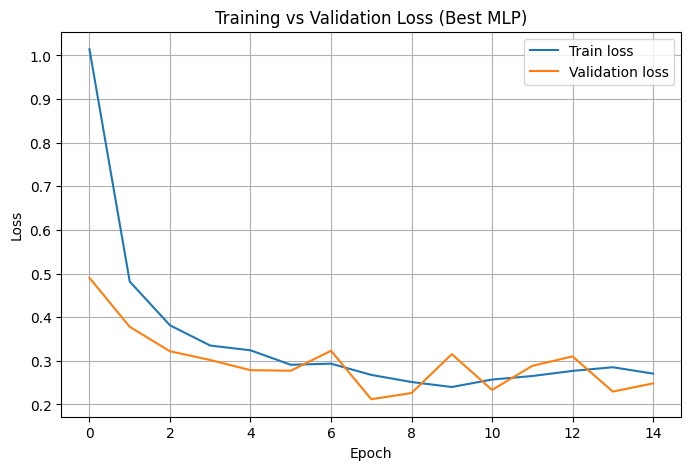

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss (Best MLP)')
plt.legend()
plt.grid(True)
plt.show()


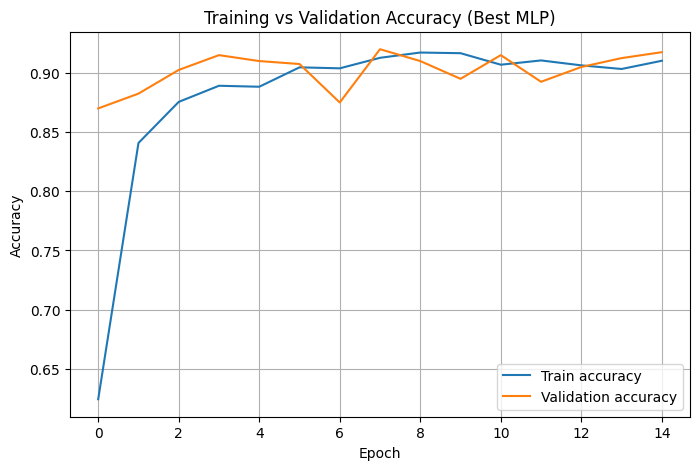

In [55]:
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy (Best MLP)')
plt.legend()
plt.grid(True)
plt.show()


In [56]:
# ============================================
# 11) EVALUATE BEST MODEL บน TEST SET
# ============================================
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# ดึง best estimator ออกมา
best_clf = grid_result.best_estimator_

# ใช้ predict บน test set (จะได้ label ตรง ๆ)
y_pred = best_clf.predict(X_test)

print("=== Test Classification Report (Best MLP from GridSearch) ===")
print(classification_report(
    y_test,
    y_pred,
    target_names=encoder.classes_
))

=== Test Classification Report (Best MLP from GridSearch) ===
              precision    recall  f1-score   support

        Bags       0.96      0.93      0.95       200
  Bottomwear       0.74      0.94      0.83       200
       Shoes       0.98      0.94      0.96       200
     Topwear       0.98      0.89      0.93       200
     Watches       0.95      0.84      0.89       200

    accuracy                           0.91      1000
   macro avg       0.92      0.91      0.91      1000
weighted avg       0.92      0.91      0.91      1000



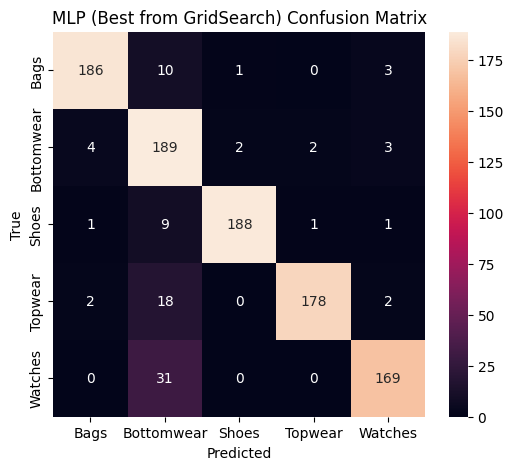

In [57]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=encoder.classes_,
    yticklabels=encoder.classes_
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("MLP (Best from GridSearch) Confusion Matrix")
plt.show()

In [58]:
# Accuracy + Macro F1
test_acc = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro')

print(f"Test Accuracy : {test_acc:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")


Test Accuracy : 0.9100
Macro F1-score: 0.9128


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
BATCH PREDICTION - ALL IMAGES IN FOLDER

📁 Found 21 images in: /content/drive/MyDrive/Test images/


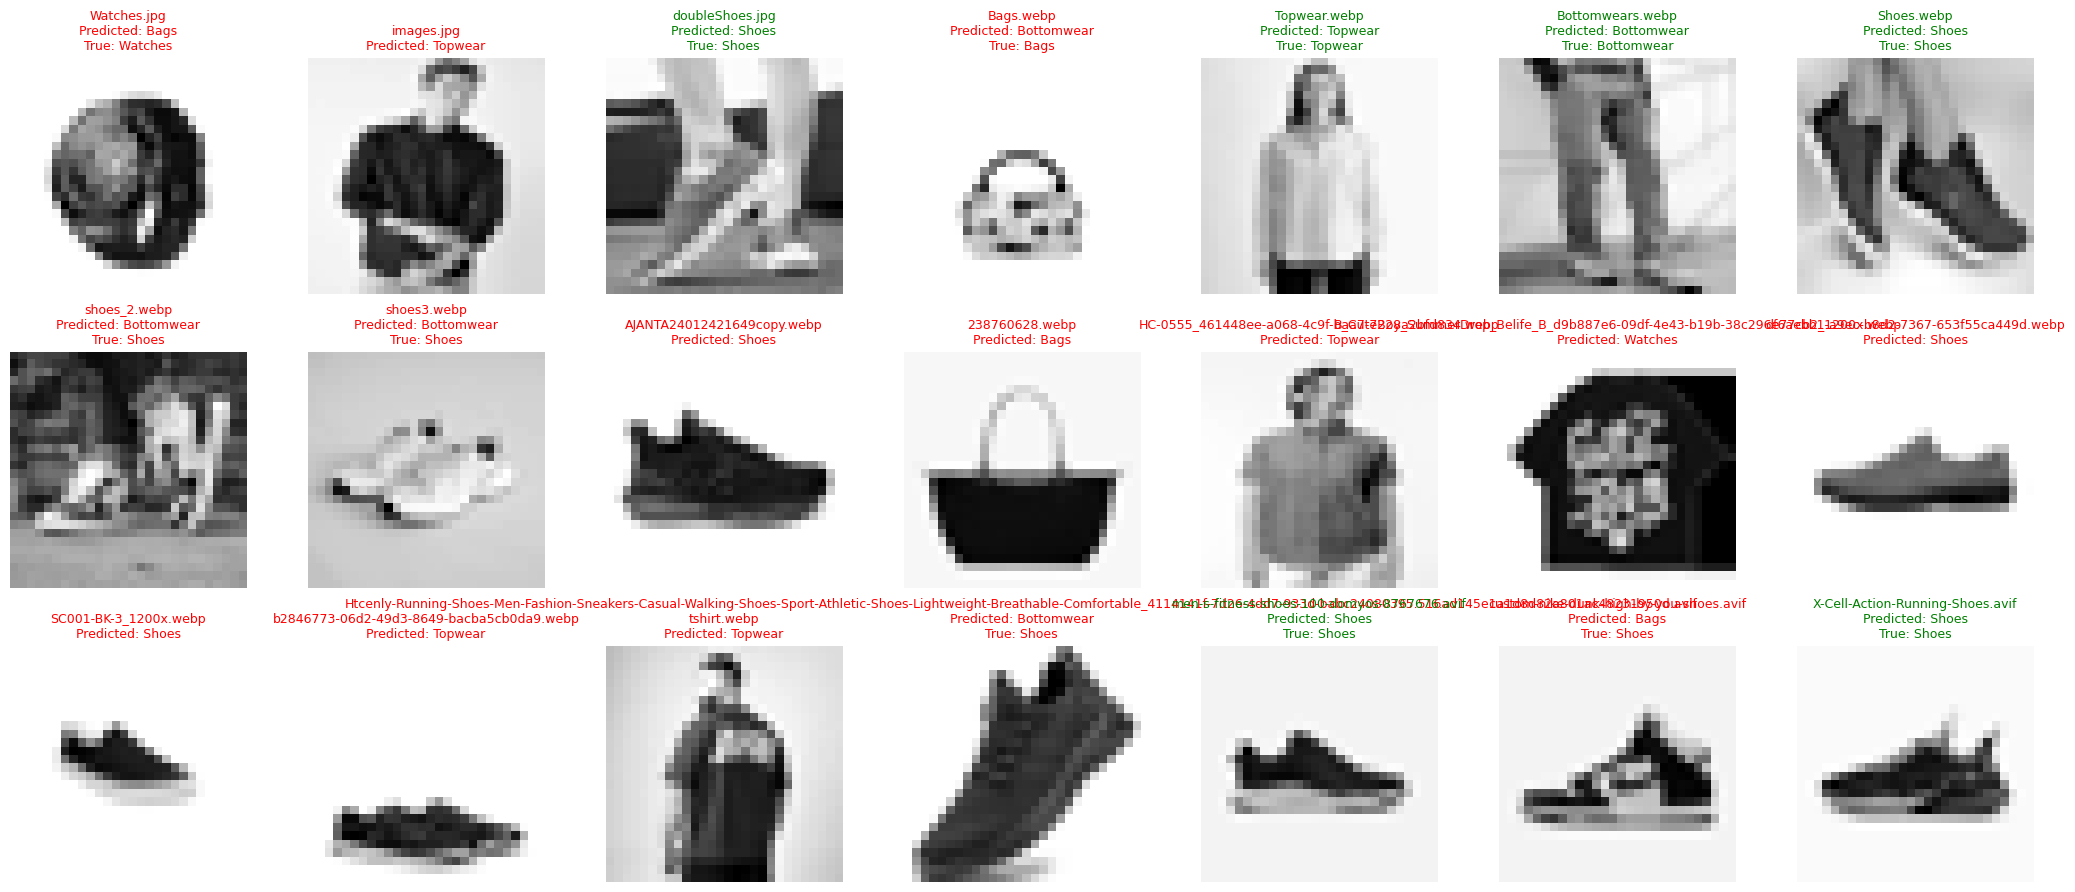


PREDICTION SUMMARY

📊 Predictions by Class:
  Bags           : 3 images
  Topwear        : 5 images
  Shoes          : 7 images
  Bottomwear     : 5 images
  Watches        : 1 images

✅ Accuracy (using filename as ground truth): 6/12 = 50.00%

📄 Detailed Results:
  Watches.jpg                    → Pred: Bags       | True: Watches    | ❌
  images.jpg                     → Pred: Topwear    | True: ?
  doubleShoes.jpg                → Pred: Shoes      | True: Shoes      | ✔️
  Bags.webp                      → Pred: Bottomwear | True: Bags       | ❌
  Topwear.webp                   → Pred: Topwear    | True: Topwear    | ✔️
  Bottomwears.webp               → Pred: Bottomwear | True: Bottomwear | ✔️
  Shoes.webp                     → Pred: Shoes      | True: Shoes      | ✔️
  shoes_2.webp                   → Pred: Bottomwear | True: Shoes      | ❌
  shoes3.webp                    → Pred: Bottomwear | True: Shoes      | ❌
  AJANTA24012421649copy.webp     → Pred: Shoes      | True: ?
  2387

In [62]:
# ============================================
# Cell: BATCH PREDICTION FROM GOOGLE DRIVE
# ============================================
from google.colab import drive
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os, glob, math
from collections import Counter

# 1) Mount Google Drive
drive.mount('/content/drive')

print('='*60)
print('BATCH PREDICTION - ALL IMAGES IN FOLDER')
print('='*60)

# 2) path ไปยังโฟลเดอร์รูปใน Drive (แกเปลี่ยนเองได้)
folder_path = '/content/drive/MyDrive/Test images/'  # แกแก้ชื่อโฟลเดอร์ตามของตัวเอง

# 3) หารูปทุกไฟล์ในโฟลเดอร์
image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG', '*.webp', '*.avif']
image_files = []
for ext in image_extensions:
    image_files.extend(glob.glob(os.path.join(folder_path, ext)))

print(f"\n📁 Found {len(image_files)} images in: {folder_path}")

if len(image_files) == 0:
    print('❌ No images found!')
else:
    results = []

    # helper: เดา true label จากชื่อไฟล์
    def get_true_label_from_name(filename):
        lower_name = filename.lower()
        for cls in encoder.classes_:
            if cls.lower() in lower_name:
                return cls
        return None   # ถ้าเดาไม่ได้

    # 4) Process ทุกภาพ
    for img_path in image_files:
        try:
            filename = os.path.basename(img_path)

            # โหลด + preprocess
            img = Image.open(img_path).convert('L').resize(image_size)
            img_np = np.array(img).astype('float32') / 255.0
            x_input = img_np.reshape(1, -1)

            # predict ด้วย best_clf
            y_pred_idx = int(best_clf.predict(x_input)[0])
            predicted_class = encoder.classes_[y_pred_idx]

            # true label จากชื่อไฟล์ (ถ้าตั้งชื่อดี ๆ)
            true_label = get_true_label_from_name(filename)

            is_correct = (true_label is not None and
                          predicted_class.lower() == true_label.lower())

            results.append({
                'filename': filename,
                'image': img_np,
                'prediction': predicted_class,
                'true_label': true_label,
                'correct': is_correct,
            })

        except Exception as e:
            print(f"⚠️ Error processing {img_path}: {e}")

    # 5) แสดงเป็น grid รูป + predicted label
    n_images = len(results)
    cols = 7
    rows = math.ceil(n_images / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    axes = axes.flatten() if n_images > 1 else [axes]

    for idx, result in enumerate(results):
        axes[idx].imshow(result['image'], cmap='gray')
        title = f"{result['filename']}\nPredicted: {result['prediction']}"
        if result['true_label'] is not None:
            title += f"\nTrue: {result['true_label']}"
        color = 'green' if result['correct'] else 'red'
        axes[idx].set_title(title, fontsize=9, color=color)
        axes[idx].axis('off')

    # ซ่อน subplot ที่เหลือ
    for idx in range(n_images, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

    # 6) SUMMARY
    print('\n' + '='*60)
    print('PREDICTION SUMMARY')
    print('='*60)

    # นับตาม predicted class
    predictions_count = Counter([r['prediction'] for r in results])
    print('\n📊 Predictions by Class:')
    for cls, count in predictions_count.items():
        print(f'  {cls:15s}: {count} images')

    # นับ accuracy (เฉพาะภาพที่เดา true label ได้จากชื่อไฟล์)
    valid_results = [r for r in results if r['true_label'] is not None]
    if len(valid_results) > 0:
        correct = sum(r['correct'] for r in valid_results)
        total = len(valid_results)
        print('\n✅ Accuracy (using filename as ground truth): '
              f'{correct}/{total} = {correct/total:.2%}')
    else:
        print('\n⚠️ No ground truth could be inferred from filenames.')

    # รายละเอียดทีละรูป
    print('\n📄 Detailed Results:')
    for r in results:
        if r['true_label'] is not None:
            print(f"  {r['filename']:30s} → Pred: {r['prediction']:10s} | True: {r['true_label']:10s} | "
                  f"{'✔️' if r['correct'] else '❌'}")
        else:
            print(f"  {r['filename']:30s} → Pred: {r['prediction']:10s} | True: ?")

    print('\n' + '='*60)
    print(f'✅ Successfully processed {len(results)}/{len(image_files)} images!')



In [63]:
# ============================================
# Cell: INTERACTIVE PREDICTION DEMO
# ============================================
from google.colab import files
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import io

print('='*60)
print('INTERACTIVE PREDICTION DEMO')
print('='*60)
print('\nChoose your upload method:')
print('1. Upload from local computer')
print('2. Use image from Google Drive')
print('='*60)

choice = input('\nEnter your choice (1 or 2): ')

uploaded = {}

if choice == '1':
    print('\n📎 Upload from local computer...')
    uploaded = files.upload()

elif choice == '2':
    from google.colab import drive
    drive.mount('/content/drive')

    print('\n📁 Enter the path to your image in Google Drive')
    print('Example: /content/drive/MyDrive/Test images/Bags.webp')
    img_path = input('Image path: ')

    if os.path.exists(img_path):
        filename = os.path.basename(img_path)
        with open(img_path, 'rb') as f:
            uploaded[filename] = f.read()
        print(f'✅ Loaded: {filename}')
    else:
        print(f'❌ File not found: {img_path}')
else:
    print('❌ Invalid choice!')

# Process uploaded images (ปกติจะมีแค่รูปเดียว)
for filename in uploaded.keys():
    print('\n' + '='*60)
    print(f'Processing: {filename}')
    print('='*60)

    # Load and preprocess image
    img_bytes = uploaded[filename]
    img = Image.open(io.BytesIO(img_bytes)).convert('L').resize(image_size)

    # Show image
    plt.figure(figsize=(4,4))
    plt.imshow(img, cmap='gray')
    plt.title(f'Uploaded Image: {filename}')
    plt.axis('off')
    plt.show()

    # Prepare for prediction
    img_array = np.array(img).astype('float32') / 255.0
    x_input = img_array.reshape(1, -1)

      # Predict
    y_pred_idx = int(best_clf.predict(x_input)[0])
    predicted_class = encoder.classes_[y_pred_idx]

    # ดึง prob แล้วบังคับให้เป็น vector 1D เสมอ
    proba_raw = best_clf.predict_proba(x_input)
    proba_raw = np.array(proba_raw)          # แปลงเป็น numpy array
    y_proba = proba_raw.ravel()              # flatten (ได้ 1D เสมอ)

    print('\n' + '='*60)
    print('PREDICTION RESULTS')
    print('='*60)
    print(f'🎯 Predicted Class: {predicted_class}')
    print(f'   Label Index    : {y_pred_idx}')

    # ถ้า length ของ prob เท่ากับจำนวน class → พิมพ์เป็นตาราง
    if len(y_proba) == len(encoder.classes_):
        print('\n📊 Class Probabilities:')
        print('-----------------------------')
        for cls, p in zip(encoder.classes_, y_proba):
            print(f'  {cls:10s}: {p:.4f}')
    else:
        # กันกรณีที่ model ดันให้ prob มาแค่ 1 ค่า (กัน error ไว้ก่อน)
        print('\n📊 Raw predict_proba output:', y_proba)

    print('='*60)
    print('\n✅ Prediction complete!')



INTERACTIVE PREDICTION DEMO

Choose your upload method:
1. Upload from local computer
2. Use image from Google Drive

Enter your choice (1 or 2): 2
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

📁 Enter the path to your image in Google Drive
Example: /content/drive/MyDrive/Test images/Bags.webp
Image path: /content/drive/MyDrive/ men-s-fitness-shoes-100-domyos-8767676.avifTest images/
❌ File not found: /content/drive/MyDrive/ men-s-fitness-shoes-100-domyos-8767676.avifTest images/
